In [1]:
import nltk
from tswift import *
import random
import pandas as pd
from langdetect import detect
import requests
import heapq 

from nltk.tokenize import wordpunct_tokenize, blankline_tokenize
import spacy

import statsmodels.api as sm
from statsmodels.sandbox.regression.predstd import wls_prediction_std
from statsmodels.stats.outliers_influence import variance_inflation_factor
from itertools import combinations
from nltk.corpus import stopwords
from time import time 
from gensim.models import Word2Vec
import multiprocessing

import xmltodict
import pprint
import json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

In [3]:
pp = pprint.PrettyPrinter(indent=4)
RANDOM_SEED = 101

In [4]:
lyrics = pd.read_csv('song_genres_10000_48751.csv')
lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     10000 non-null  int64 
 1   artist         10000 non-null  object
 2   song_name      10000 non-null  object
 3   closest_genre  10000 non-null  object
 4   lyric          10000 non-null  object
dtypes: int64(1), object(4)
memory usage: 390.8+ KB


In [5]:
lyrics.describe()

,Unnamed: 0
count,10000.00000
mean,4999.50000
std,2886.89568
min,0.00000
25%,2499.75000
50%,4999.50000
75%,7499.25000
max,9999.00000


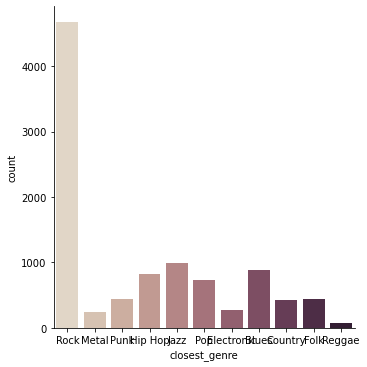

In [6]:
sns.catplot(x="closest_genre", kind="count", palette="ch:.25", data=lyrics)

In [7]:
lyrics.groupby('closest_genre')['song_name'].nunique().sort_values()

closest_genre
Reggae          72
Metal          236
Electronic     270
Country        394
Folk           419
Punk           424
Pop            652
Hip Hop        782
Blues          835
Jazz           855
Rock          4344
Name: song_name, dtype: int64

In [ ]:
lyrics['length_lyric'] = lyrics.lyric.apply(lambda x: len(x.split()))

In [8]:
threshold = lyrics.groupby('closest_genre')['song_name'].nunique()['Metal']
cleaned_lyrics = lyrics[lyrics.closest_genre!='Reggae']
cleaned_lyrics = cleaned_lyrics.groupby('closest_genre').sample(n=threshold, random_state=RANDOM_SEED)

In [9]:
cleaned_lyrics.groupby('closest_genre')['song_name'].nunique()

closest_genre
Blues         233
Country       226
Electronic    230
Folk          229
Hip Hop       234
Jazz          231
Metal         232
Pop           223
Punk          230
Rock          234
Name: song_name, dtype: int64

In [10]:
cleaned_lyrics.groupby('closest_genre')['song_name'].sum()

closest_genre
Blues         My Baby Made A ChangeGuess WhoDon't Play That ...
Country       Texas (When I Die)Is There Life Out ThereFlesh...
Electronic    World in My Eyes - 2006 RemasterWe Will Rock Y...
Folk          Sunday Mornin' Comin' DownRailroad BillHush-A-...
Hip Hop       Rabbit RunLebanese BlondeSing For The MomentMo...
Jazz          East of the Sun (West of the Moon)Night Lights...
Metal         Inside Four Walls - live at the Zeche Bochum, ...
Pop           One Bad AppleGimme Gimme Good Lovin'Andante, A...
Punk          100 Years from NowWaiting RoomBro HymnOh Yeah ...
Rock          Sure ShotBirth Of The BoogieLady Love - 2007 R...
Name: song_name, dtype: object

In [11]:
length_of_lyrics_per_genre = {}
for i, a in cleaned_lyrics.groupby('closest_genre')['lyric'].sum().iteritems():
    length_of_lyrics_per_genre[i] = len(a)

In [12]:
length_of_lyrics_per_genre

{'Blues': 261966,
 'Country': 273062,
 'Electronic': 275107,
 'Folk': 269825,
 'Hip Hop': 538538,
 'Jazz': 209723,
 'Metal': 259959,
 'Pop': 304841,
 'Punk': 274733,
 'Rock': 257901}

<BarContainer object of 10 artists>

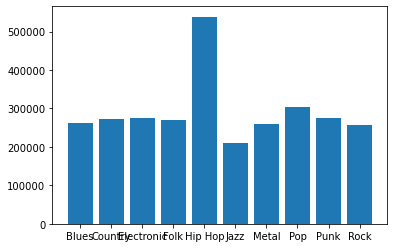

In [13]:
plt.bar(length_of_lyrics_per_genre.keys(), length_of_lyrics_per_genre.values())

In [14]:
unique_words_per_genre = {}
length_unique_words_per_genre = {}
for genre, lyric in cleaned_lyrics.groupby('closest_genre')['lyric'].sum().iteritems():
    text = lyric.lower()
    tokens = wordpunct_tokenize(text)
    unique_words_per_genre[genre] = set(tokens)
    length_unique_words_per_genre[genre] = len(set(tokens))

<BarContainer object of 10 artists>

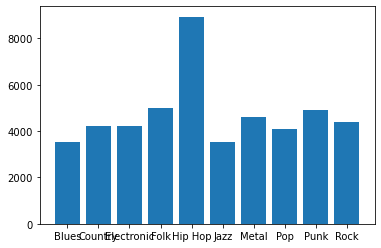

In [15]:
plt.bar(length_unique_words_per_genre.keys(), length_unique_words_per_genre.values())

In [16]:
freq_unique_words_per_genre = {}
stop_words = stopwords.words('english')
sentences = []
for genre, lyric in cleaned_lyrics.groupby('closest_genre')['lyric'].sum().iteritems():
    text = lyric.lower()
    tokens = wordpunct_tokenize(text)
    filtered_sentence = [w for w in tokens if (not w in stop_words) and (w.isalpha())] 
    sentences += filtered_sentence
    fdist1 = nltk.FreqDist(filtered_sentence)
    freq_unique_words_per_genre[genre] = dict((word, freq) for word, freq in fdist1.items() if word.isalpha())


In [17]:
sentences_1 = [sent.split() for sent in sentences]

In [18]:
sentences_1[:10]

[['well'],
 ['building'],
 ['inside'],
 ['oh'],
 ['know'],
 ['long'],
 ['know'],
 ['keep'],
 ['thinking'],
 ['something']]

In [19]:
common_terms = []
for key in freq_unique_words_per_genre.keys():
    common_terms += heapq.nlargest(100, freq_unique_words_per_genre[key], key=freq_unique_words_per_genre[key].get)
common_terms = set(common_terms)

In [20]:
len(common_terms)

263

In [21]:
from gensim.models.phrases import Phrases, Phraser

In [245]:
phrases = Phrases(sentences_1, common_terms=common_terms, min_count=10)
ngram = Phraser(phrases)

INFO - 16:46:39: collecting all words and their counts
INFO - 16:46:39: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 16:46:39: PROGRESS: at sentence #10000, processed 10000 words and 1653 word types
INFO - 16:46:39: PROGRESS: at sentence #20000, processed 20000 words and 2610 word types
INFO - 16:46:39: PROGRESS: at sentence #30000, processed 30000 words and 3366 word types
INFO - 16:46:39: PROGRESS: at sentence #40000, processed 40000 words and 4361 word types
INFO - 16:46:39: PROGRESS: at sentence #50000, processed 50000 words and 5050 word types
INFO - 16:46:39: PROGRESS: at sentence #60000, processed 60000 words and 5716 word types
INFO - 16:46:39: PROGRESS: at sentence #70000, processed 70000 words and 6316 word types
INFO - 16:46:39: PROGRESS: at sentence #80000, processed 80000 words and 7078 word types
INFO - 16:46:39: PROGRESS: at sentence #90000, processed 90000 words and 7778 word types
INFO - 16:46:39: PROGRESS: at sentence #100000, processed 100000 w

In [246]:
ngrams_sent = list(ngram[sentences_1])

In [116]:
# cleaned_lyrics_txt = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in cleaned_lyrics['lyric'])

In [117]:
# nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed


In [118]:
# def cleaning(doc):
#     # Lemmatizes and removes stopwords
#     # doc needs to be a spacy Doc object
#     txt = [token.lemma_ for token in doc if not token.is_stop]
#     # Word2Vec uses context words to learn the vector representation of a target word,
#     # if a sentence is only one or two words long,
#     # the benefit for the training is very small
#     if len(txt) > 2:
#         return ' '.join(txt)

In [119]:
# t = time()

# txt = [cleaning(doc) for doc in nlp.pipe(cleaned_lyrics, batch_size=50)]

# print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.71 mins


In [ ]:
# df_clean = pd.DataFrame({'clean': txt})
# df_clean = df_clean.dropna().drop_duplicates()
# df_clean.shape

- min_count = int - Ignores all words with total absolute frequency lower than this - (2, 100)
- window = int - The maximum distance between the current and predicted word within a sentence. E.g. window words on the left and window words on the left of our target - (2, 10)
- size = int - Dimensionality of the feature vectors. - (50, 300)
- sample = float - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial. - (0, 1e-5)
- alpha = float - The initial learning rate - (0.01, 0.05)
- min_alpha = float - Learning rate will linearly drop to min_alpha as training progresses. To - set it: alpha - (min_alpha * epochs) ~ 0.00
- negative = int - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)
- workers = int - Use these many worker threads to train the model (=faster training with multicore machines)

In [25]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

In [26]:
w2v_model = Word2Vec(min_count=10,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

In [248]:
t = time()

w2v_model.build_vocab(ngrams_sent, progress_per=1000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 16:47:09: collecting all words and their counts
INFO - 16:47:09: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 16:47:09: PROGRESS: at sentence #1000, processed 1000 words, keeping 368 word types
INFO - 16:47:09: PROGRESS: at sentence #2000, processed 2000 words, keeping 647 word types
INFO - 16:47:09: PROGRESS: at sentence #3000, processed 3000 words, keeping 877 word types
INFO - 16:47:09: PROGRESS: at sentence #4000, processed 4000 words, keeping 1004 word types
INFO - 16:47:09: PROGRESS: at sentence #5000, processed 5000 words, keeping 1168 word types
INFO - 16:47:09: PROGRESS: at sentence #6000, processed 6000 words, keeping 1363 word types
INFO - 16:47:09: PROGRESS: at sentence #7000, processed 7000 words, keeping 1525 word types
INFO - 16:47:09: PROGRESS: at sentence #8000, processed 8000 words, keeping 1621 word types
INFO - 16:47:09: PROGRESS: at sentence #9000, processed 9000 words, keeping 1743 word types
INFO - 16:47:09: PROGRESS: at sentenc

In [249]:
phrasest = time()

w2v_model.train(ngrams_sent, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 16:47:12: training model with 11 workers on 3268 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 16:47:12: worker thread finished; awaiting finish of 10 more threads
INFO - 16:47:12: worker thread finished; awaiting finish of 9 more threads
INFO - 16:47:12: worker thread finished; awaiting finish of 8 more threads
INFO - 16:47:12: worker thread finished; awaiting finish of 7 more threads
INFO - 16:47:12: worker thread finished; awaiting finish of 6 more threads
INFO - 16:47:12: worker thread finished; awaiting finish of 5 more threads
INFO - 16:47:12: worker thread finished; awaiting finish of 4 more threads
INFO - 16:47:12: worker thread finished; awaiting finish of 3 more threads
INFO - 16:47:12: worker thread finished; awaiting finish of 2 more threads
INFO - 16:47:12: worker thread finished; awaiting finish of 1 more threads
INFO - 16:47:12: worker thread finished; awaiting finish of 0 more threads
INFO - 16:47:12: EPOCH - 1 : training o

In [29]:
w2v_model.most_similar('bird')

INFO - 10:43:44: precomputing L2-norms of word weight vectors


[('stops', 0.1837897151708603),
 ('useless', 0.18139329552650452),
 ('kokomo', 0.17612582445144653),
 ('brat', 0.1740562915802002),
 ('dooda', 0.17127007246017456),
 ('record', 0.1690666526556015),
 ('rainy', 0.166599303483963),
 ('betty', 0.16588854789733887),
 ('changes', 0.16447213292121887),
 ('bees', 0.16358034312725067)]

In [30]:
w2v_model.vector_size

300

In [28]:
# w2v_model.save("tenKlyricswv.model")
w2v_model = Word2Vec.load("tenKlyricswv.model")

INFO - 10:43:39: loading Word2Vec object from tenKlyricswv.model
INFO - 10:43:40: loading wv recursively from tenKlyricswv.model.wv.* with mmap=None
INFO - 10:43:40: setting ignored attribute vectors_norm to None
INFO - 10:43:40: loading vocabulary recursively from tenKlyricswv.model.vocabulary.* with mmap=None
INFO - 10:43:40: loading trainables recursively from tenKlyricswv.model.trainables.* with mmap=None
INFO - 10:43:40: setting ignored attribute cum_table to None
INFO - 10:43:40: loaded tenKlyricswv.model


In [297]:
w2v_model.wv.save('tenklyricsvocab.kv')

INFO - 10:12:47: saving Word2VecKeyedVectors object under tenklyricsvocab.kv, separately None
INFO - 10:12:47: not storing attribute vectors_norm
INFO - 10:12:47: saved tenklyricsvocab.kv


In [31]:
# Pytorch
import torch.nn as nn
import torch.nn.functional as f
import torch
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split

In [32]:
cleaned_lyrics.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2360 entries, 8501 to 2004
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Unnamed: 0     2360 non-null   int64 
 1   artist         2360 non-null   object
 2   song_name      2360 non-null   object
 3   closest_genre  2360 non-null   object
 4   lyric          2360 non-null   object
dtypes: int64(1), object(4)
memory usage: 110.6+ KB


In [45]:
embedding_matrix = torch.FloatTensor(w2v_model.wv.vectors)
word2idx = {
    word:idx for idx, word in enumerate(w2v_model.wv.vocab, start=2)
}
embedding_matrix.shape

torch.Size([3268, 300])

In [42]:
w2v_model.wv.syn0.shape

(3268, 300)

In [34]:
X = cleaned_lyrics['lyric']
y = cleaned_lyrics['closest_genre']

In [290]:
X

,Unnamed: 0,artist,song_name
8501,8501,Sonny Boy Williamson I,My Baby Made A Change
9993,9993,B.B. King,Guess Who
3415,3415,Ben E. King,Don't Play That Song (You Lied) - Mono
9698,9698,Marlena Shaw,Woman Of The Ghetto
4951,4951,Stevie Wonder,Summer Soft
...,...,...,...
4083,4083,The Rolling Stones,Love In Vain
4925,4925,James Taylor,How Sweet It Is (To Be Loved by You)
8979,8979,Johnny Horton,"I'm Ready, If You're Willing"
130,130,The Spencer Davis Group,I'm A Man


In [44]:
TEST_SIZE = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_SEED)

In [82]:
max_sentence_length = X.apply(lambda x: x.split(" ")).apply(len).max()
max_sentence_length

973

In [85]:
min_sentence_length = X.apply(lambda x: x.split(" ")).apply(len).min()
min_sentence_length

4

In [56]:
 [
    cleaned_lyrics.lyric.apply(lambda x: x.split(" "))
][0]

8501    [Well, its, been, building, up, inside, of, me...
9993    [Someone, really, loves, you\nGuess, who\nSome...
3415    [Chestnuts, roasting, on, an, open, fire\nJack...
9698    [(ging,, gi-gi-gi-gi-ging...)\n(la-la-la-la-la...
4951    [I, never, dreamed, you'd, leave, in, summer\n...
                              ...                        
4083    [(Russell/Burke/Wexler)\n\nSpoken:\n\nI'm, so,...
4925    [first, recorded, by, writer, Columbo, in, 193...
8979    [If, the, good, Lord's, willing, and, the, cre...
130     [Well, my, pad, is, very, messy\nAnd, there's,...
2004    [maybe, maybe, nothing, could, prepare, you\nb...
Name: lyric, Length: 2360, dtype: object

In [79]:
X_train_set = (X_train.apply(
        lambda x: list(map(lambda word: word2idx[word] if word in word2idx else 1, x.split(" ")))))
print(X_train_set.iloc[0])

[1, 1, 1, 1, 1174, 1, 1174, 1, 1, 1, 1, 1174, 1, 1174, 1, 1, 1, 1, 1, 577, 1, 1, 1, 1, 1, 1, 295, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 577, 1, 1869, 1869, 1, 1, 577, 1, 1869, 1869, 1, 1, 1, 1, 1, 1, 1, 1, 411, 1, 1, 1, 1, 1, 1, 1, 79, 1, 1, 1, 1, 1, 1, 12, 1, 577, 1, 1869, 1869, 1, 1, 577, 1, 1869, 1869, 1, 1, 1, 1, 1, 1869, 1, 1, 1, 1, 1, 1869, 1, 1, 1, 1, 1, 1174, 1, 1174, 1, 1, 1, 58, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 505, 1, 1, 1, 1, 577, 1, 1869, 1869, 1, 1, 577, 1, 1869, 1869, 1, 1, 1, 1]


pandas.core.series.Series

In [74]:
# padding sequence
# Perlu atau tidak?
# Ubah ke torch tensor
X_train_set = (
    list(
        map(
            lambda x: torch.LongTensor(x), X_train_set
        )
    )
)

TypeError: only integer tensors of a single element can be converted to an index

In [272]:
classes = cleaned_lyrics.closest_genre.unique()
pp.pprint(classes)

array(['Blues', 'Country', 'Electronic', 'Folk', 'Hip Hop', 'Jazz',
       'Metal', 'Pop', 'Punk', 'Rock'], dtype=object)


In [265]:
train_on_gpu = torch.cuda.is_available()
lstm_args = {
    'batch_size':,
    'hidden_dim':,
    'lstm_layers':,
    'max_words':,
}

In [ ]:
# Simple LSTM Model
class Simple_LSTM(nn.Module):
	def __init__(self, args):
		super(Simple_LSTM, self).__init__()
		
		# Hyperparameters
		self.batch_size = args.batch_size
		self.hidden_dim = args.hidden_dim
		self.LSTM_layers = args.lstm_layers
		self.input_size = args.max_words
		
		self.dropout = nn.Dropout(0.5)
		self.embedding = nn.Embedding(self.input_size, self.hidden_dim, padding_idx=0)
		self.lstm = nn.LSTM(input_size=self.hidden_dim, hidden_size=self.hidden_dim, num_layers=self.LSTM_layers, batch_first=True)
		self.fc1 = nn.Linear(in_features=self.hidden_dim, out_features=self.hidden_dim*2)
		self.fc2 = nn.Linear(self.hidden_dim*2, 1)
		
	def forward(self, x):
		
		# Hidden and cell state definion
		h = torch.zeros((self.LSTM_layers, x.size(0), self.hidden_dim))
		c = torch.zeros((self.LSTM_layers, x.size(0), self.hidden_dim))
		
		# Initialization fo hidden and cell states
		torch.nn.init.xavier_normal_(h)
		torch.nn.init.xavier_normal_(c)

		# Each sequence "x" is passed through an embedding layer
		out = self.embedding(x)
		# Feed LSTMs
		out, (hidden, cell) = self.lstm(out, (h,c))
		out = self.dropout(out)
		# The last hidden state is taken
		out = torch.relu_(self.fc1(out[:,-1,:]))
		out = self.dropout(out)
		out = torch.sigmoid(self.fc2(out))

		return out

In [ ]:
class DatasetMaper(Dataset):
	'''
	Handles batches of dataset
	'''
  
	def __init__(self, x, y):
		self.x = x
		self.y = y
		
	def __len__(self):
		return len(self.x)
		
	def __getitem__(self, idx):
		return self.x[idx], self.y[idx]

training_set = DatasetMaper(x_train, y_train)
test_set = DatasetMaper(x_test, y_test)
		
loader_training = DataLoader(training_set, batch_size=batch_size)
loader_test = DataLoader(test_set)

In [266]:
def train_model(model, epochs=10, lr=0.001):
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr)
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        for x, y, l in train_dl:
            x = x.long()
            y = y.long()
            y_pred = model(x, l)
            optimizer.zero_grad()
            loss = F.cross_entropy(y_pred, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
        val_loss, val_acc, val_rmse = validation_metrics(model, val_dl)
        if i % 5 == 1:
            print("train loss %.3f, val loss %.3f, val accuracy %.3f, and val rmse %.3f" % (sum_loss/total, val_loss, val_acc, val_rmse))


In [267]:
def validation_metrics (model, valid_dl):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_rmse = 0.0
    for x, y, l in valid_dl:
        x = x.long()
        y = y.long()
        y_hat = model(x, l)
        loss = F.cross_entropy(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
        sum_rmse += np.sqrt(mean_squared_error(pred, y.unsqueeze(-1)))*y.shape[0]
    return sum_loss/total, correct/total, sum_rmse/total

In [ ]:
train_model(model, epochs=30, lr=0.01)